In [95]:
# aux imports
import numpy as np
import pandas as pd
from plotnine import ggplot, aes, geom_line, geom_vline, geom_hline, ylab, xlab

# keras imports
from keras.layers import Dense
from keras.models import Sequential
from keras.callbacks import LambdaCallback

# sklearn imports
from sklearn.datasets import fetch_mldata
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split, StratifiedKFold

In [2]:
mnist = fetch_mldata('MNIST original')

In [3]:
lb = LabelBinarizer()
y = lb.fit(mnist.target).transform(mnist.target)

In [4]:
X_train, X_test, y_train , y_test  = train_test_split(mnist.data, y, test_size=0.2)

In [11]:
def get_model(hidden_unit_size):
    ''' Creates a 2-layers fully connected neural network
        for the mnist dataset.
        The neural net's layer size are the following:
        [784, hidden_unit_size, 10]
        
    :param hidden_unit_size: int.
        the size of the hidden layer
    :return: keras.models.Sequential
    '''
    model = Sequential()

    model.add(Dense(hidden_unit_size, activation='sigmoid', input_shape=(784,)))
    model.add(Dense(10, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
    return model

In [106]:
hidden_unit_sizes = 2 ** np.arange(3, 14) 
hidden_unit_sizes 

array([   8,   16,   32,   64,  128,  256,  512, 1024, 2048, 4096, 8192])

In [108]:
epochs = 5
accs = []
test_errors = np.ones(hidden_unit_sizes.shape[0])

# callback for retrieving training info.
# the info will be plotted subsequently.
logging_callback = LambdaCallback(
    on_epoch_end=lambda epoch, logs: accs.append(logs),
)

norm = hidden_unit_sizes.sum()
total_trained = 0
for i, hidden_unit_size in enumerate(hidden_unit_sizes):
    model = get_model(hidden_unit_size)
    # training neural net
    model.fit(X_train, y_train, 
              epochs = epochs,
              verbose=0,
              batch_size=256,
              validation_split=0.2,
              callbacks=[logging_callback])
    
    y_pred = np.argmax(model.predict(X_test), axis=1)
    test_errors[i] = np.mean(y_pred != np.argmax(y_test, axis=1))
    total_trained += hidden_unit_size / norm
    print('Trained: {:.2f}%'.format(total_trained * 100), end="\r")

# pandas dataframe with the training info
results = pd.DataFrame(accs)
results['size']  = np.repeat(hidden_unit_sizes, epochs)
results['epoch']  = np.tile(np.arange(epochs), hidden_unit_sizes.shape[0])

/home/raphael/Documents/mlrei/.venv/lib/python3.5/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


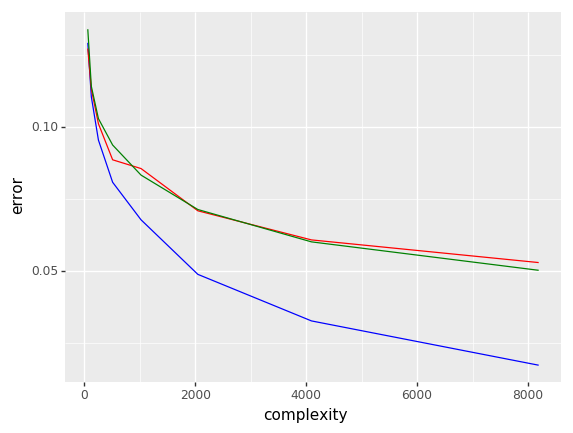

<ggplot: (8781743111253)>

In [109]:
# filtering dataframe.
# we are interested only in the last epoch
last_epoch_results = results[results.
                                groupby('size').
                                epoch.
                                apply(lambda x: x == x.max())]
last_epoch_results['test_errors'] = test_errors

# ploting trainig and validation error vs model complexity.
ggplot(last_epoch_results.iloc[3:], aes(x='size')) + \
geom_line(aes(y='1 - acc'), color='blue') + \
geom_line(aes(y='1 - val_acc'), color='red') + \
geom_line(aes(y='test_errors'), color='green') + \
ylab('error') + xlab('complexity')